# Artificial Intelligence (CS6364-002) 
## Homework 8
## Submission by - Adithya Sundararajan Iyer (asi200000)


The following article “Sentiment Analysis using LSTM (Step-by-Step Tutorial)” demonstrates how to build a classifier for sentimental analysis on an IMDB movie dataset using the LSTM model:
https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948

In [8]:
import torch
import torch.nn as nn
import numpy as np


Adapt the code in the tutorial “Sentiment Analysis using LSTM (Step-by-Step Tutorial)” to build a LSTM-based classifier for sentiment analysis on the following twitter dataset. In this adaption, please also modify the architecture of the LSTM model to use two fully connected layers (FCL), instead of one FCL. About the hyperparameters, the first FCL has 128 neurons and ReLU as the activation function. The second FUL has 1 neuron and sigmoid as the activation function.

Kaggle Link for Twitter 1.6Mil dataset: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

## 1. Load in and visualize the data

In [9]:
import pandas as pd
import csv

cols = ['target', 'ids', 'date', 'flag', 'user', 'text']

# df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=cols, quoting=csv.QUOTE_NONE, index_col=None)
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=cols, error_bad_lines=False)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df = df.sample(frac=0.25)
df.head()

,target,ids,date,flag,user,text
576813,0,2212067843,Wed Jun 17 13:38:04 PDT 2009,NO_QUERY,Petra26,"@bloodrose_ really to London, thatÂ´s great. I..."
1101237,4,1970737074,Sat May 30 05:01:54 PDT 2009,NO_QUERY,frackgirl89,Off to work. Only 5 hours though. Crosses fing...
1549044,4,2183226232,Mon Jun 15 14:12:59 PDT 2009,NO_QUERY,rlangdon,My whereabouts tonight? The Drake; 8 p.m.; wit...
134344,0,1836229833,Mon May 18 07:37:13 PDT 2009,NO_QUERY,megsstudio,@themes4bb I got a case of the Mondays
453914,0,2070458755,Sun Jun 07 17:43:56 PDT 2009,NO_QUERY,davelewistwit,@SkyNews calling a seat for Nazi Nick in NW #...


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 576813 to 585592
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  400000 non-null  int64 
 1   ids     400000 non-null  int64 
 2   date    400000 non-null  object
 3   flag    400000 non-null  object
 4   user    400000 non-null  object
 5   text    400000 non-null  object
dtypes: int64(2), object(4)
memory usage: 21.4+ MB


In [12]:
df.shape

(400000, 6)

In [13]:
df.describe(include='all')

,target,ids,date,flag,user,text
count,400000.000000,4.000000e+05,400000,400000,400000,400000
unique,NaN,NaN,311964,1,256069,397653
top,NaN,NaN,Fri Jun 05 11:00:08 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,8,400000,157,63
mean,2.002360,1.998701e+09,NaN,NaN,NaN,NaN
std,2.000001,1.936593e+08,NaN,NaN,NaN,NaN
min,0.000000,1.467813e+09,NaN,NaN,NaN,NaN
25%,0.000000,1.956925e+09,NaN,NaN,NaN,NaN
50%,4.000000,2.002205e+09,NaN,NaN,NaN,NaN
75%,4.000000,2.177001e+09,NaN,NaN,NaN,NaN


Dropping the unnecessary columns

In [14]:
df = df.drop(labels=['ids', 'date', 'flag', 'user'], axis=1)
df.head()

,target,text
576813,0,"@bloodrose_ really to London, thatÂ´s great. I..."
1101237,4,Off to work. Only 5 hours though. Crosses fing...
1549044,4,My whereabouts tonight? The Drake; 8 p.m.; wit...
134344,0,@themes4bb I got a case of the Mondays
453914,0,@SkyNews calling a seat for Nazi Nick in NW #...


In [15]:
# labels, tweets = [], []
labels = df.get('target').tolist()
tweets = df.get('text').tolist()

print(labels[:5])
print(tweets[:5])

[0, 4, 4, 0, 0]
['@bloodrose_ really to London, thatÂ´s great. I hope IÂ´ll go like au-pair in the UK, but I must wait if they choose me  Not fine feeling', 'Off to work. Only 5 hours though. Crosses fingers that it goes quick so my weekend can start. ', "My whereabouts tonight? The Drake; 8 p.m.; with some @FreshBooks customers and friends before tomorrow's #freshbooksworkshop ", '@themes4bb I got a case of the Mondays ', ' @SkyNews calling a seat for Nazi Nick in NW #eu09']


## 2. Data Pre-processing

In [16]:
from string import punctuation

l = len(tweets) 
for i in range(l):
    tweet = tweets[i]
    twt = []
    for word in tweet.split():
        if word[0]=='@':
            continue # ignoring mentions
        if word.startswith('http'):
            continue # ignoring hyperlinks
        twt.append(word.lower()) # convert to lowercase
    twt = ' '.join(twt)
    twt = ''.join([c for c in twt if c not in punctuation]) # remove punctuation
    tweets[i] = twt
print(tweets[:5])

['really to london thatâ´s great i hope iâ´ll go like aupair in the uk but i must wait if they choose me not fine feeling', 'off to work only 5 hours though crosses fingers that it goes quick so my weekend can start', 'my whereabouts tonight the drake 8 pm with some customers and friends before tomorrows freshbooksworkshop', 'i got a case of the mondays', 'calling a seat for nazi nick in nw eu09']


## 3. Tokenize — Create Vocab to Int mapping dictionary

In [17]:
from collections import Counter

words = []
for twt in tweets:
    words.extend(twt.split())
cntWrds = Counter(words)
srtdWrds = cntWrds.most_common()
hashmap = {w:i+1 for i, (w,c) in enumerate(srtdWrds)}


In [18]:
dict(list(hashmap.items())[:5])

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5}

## 4. Tokenize — Encode the words and labels

In [19]:
encTweets = [[hashmap[wrd] for wrd in tweet.split()] for tweet in tweets]
encLabels = [1 if label==4 else 0 for label in labels]

print(encLabels[:5])
print(encTweets[:5])

[0, 1, 1, 0, 0]
[[60, 2, 707, 13033, 92, 1, 94, 9549, 38, 36, 55222, 11, 3, 814, 19, 1, 323, 138, 67, 90, 1949, 15, 25, 529, 182], [85, 2, 46, 108, 342, 211, 129, 9550, 1091, 18, 9, 513, 1099, 16, 5, 154, 63, 263], [5, 19754, 121, 3, 6252, 552, 1223, 21, 65, 3392, 6, 190, 214, 2145, 55223], [1, 48, 4, 919, 12, 3, 1768], [1159, 4, 2188, 10, 11353, 1115, 11, 4327, 8444]]


## 5. Standardize tweet length

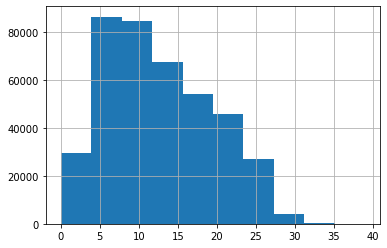

count    400000.000000
mean         12.483400
std           6.902399
min           0.000000
25%           7.000000
50%          11.000000
75%          18.000000
max          39.000000
dtype: float64

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

twtLen = [len(x) for x in encTweets]
pd.Series(twtLen).hist()
plt.show()
pd.Series(twtLen).describe()

In [21]:
encTweets = [ encTweets[i] for i, l in enumerate(twtLen) if l>0 ]
encLabels = [ encLabels[i] for i, l in enumerate(twtLen) if l>0 ]

In [22]:
def pad_features(tweetVec, seqLength):
    
    features = np.zeros((len(tweetVec), seqLength), dtype = int)
    
    for i, twt in enumerate(tweetVec):
        twtLen = len(twt)
        if twtLen < seqLength:
            zeroes = list(np.zeros(seqLength-twtLen))
            mod = zeroes + twt
        elif twtLen > seqLength:
            mod = twt[:seqLength]
        else:
            mod = twt
        features[i,:] = np.array(mod)
    
    return features


In [23]:
features = pad_features(encTweets, 12)
print(features[:5])

[[   60     2   707 13033    92     1    94  9549    38    36 55222    11]
 [   85     2    46   108   342   211   129  9550  1091    18     9   513]
 [    5 19754   121     3  6252   552  1223    21    65  3392     6   190]
 [    0     0     0     0     0     1    48     4   919    12     3  1768]
 [    0     0     0  1159     4  2188    10 11353  1115    11  4327  8444]]


## 6. Training, Validation, Test Data Split

In [24]:
# train= 80% | valid = 10% | test = 10%
split_frac = 0.8
feats = len(features)
train_x = features[:int(split_frac*feats)]
train_y = encLabels[:int(split_frac*feats)]
remaining_x = features[int(split_frac*feats):]
remaining_y = encLabels[int(split_frac*feats):]
valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]
test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]
print(len(train_y),len(valid_y),len(test_y))

319350 39919 39919


## 7. Dataloaders and Batching

In [28]:
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(valid_x)), torch.from_numpy(np.array(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))
# dataloaders
batch_size = 20
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([20, 12])
Sample input: 
 tensor([[   75,    10,     3,  1023,  1374,   617,     1,    63,   484,     3,
          2967,   251],
        [   18,   252,    13,  4255,    28,    47,  1018,   341,   257,   526,
           451,  1031],
        [    0,     0,     0,     0,     0,     0,     0,    56, 16758,    61,
             1,   328],
        [    0,     0,     0,     0,     0,     0,  1195,     3,    49,    97,
           122,  2042],
        [  132,    46,    57,    32,  5513,    21,   270,   567,  3611,    19,
             1,   351],
        [    0,     0,     0,    13,   177,    37,    46,    40,   102,    96,
           335, 61158],
        [50334,   833,    18,    67,     7,    36,    27,    98,    41,     3,
           241,    67],
        [ 5538,   155, 10465,    77,     1,    32,     3,  3396,  1322,    13,
            30, 30703],
        [   57,   221,   462,     2,  1000,    14,    18,    13,    25,    18,
          4509,    21],
        [    0, 

## 8. Define the LSTM Network Architecture

In [29]:
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        # linear and sigmoid layers
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout
        out = self.dropout(lstm_out)
        # fully-connected layer 1
        out = self.fc1(out)
        # relu function
        relu_out = self.relu(out)
        # fully-connected layer 2
        out = self.fc2(relu_out)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden


## 9. Training the network

### Instantiate the network

In [30]:
# Instantiate the model w/ hyperparams
vocab_size = len(hashmap)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(173996, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training Loop

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 3

counter = 0
print_every = 100
clip=5 # gradient clipping

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


## 10. Testing

### On Test Data

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

### On User-Generated Data

In [ ]:
def tokenize_tweet(test_tweet):
    test_tweet = test_tweet.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_tweet if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([hashmap[word] for word in test_words])

    return test_ints

# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())


def predict(net, test_tweet, sequence_length=20):
    
    net.eval()
    
    # tokenize tweet
    test_ints = tokenize_tweet(test_tweet)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Label=4 detected!")
    else:
        print("Label=0 detected.")

In [ ]:
tw1 = '@marvel I did not enjoy the new superhero movie :('
tw2 = '@potus I think the elections are rigged..?'
tw3 = 'Loving the weather in Austin right now!'
predict(net, tw1)
predict(net, tw2)
predict(net, tw3)